In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
from bs4 import BeautifulSoup
import time
import seaborn as sns
# import folium


In [3]:
data = pd.read_csv('houses_current.csv')
data.head()
len(data)

9674

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9674 entries, 0 to 9673
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   houseTypes  9674 non-null   object 
 1   area        9497 non-null   float64
 2   num_floors  7706 non-null   float64
 3   bedrooms    7577 non-null   float64
 4   address     9674 non-null   object 
 5   price       9548 non-null   float64
 6   url         9674 non-null   object 
dtypes: float64(4), object(3)
memory usage: 529.2+ KB


REMOVE DUPLICATES

In [5]:
print('Sum of duplicates: ', data.duplicated(subset=['houseTypes', 'area', 'num_floors', 'bedrooms','address','price']).sum())
data = data.drop_duplicates(subset=['houseTypes', 'area', 'num_floors', 'bedrooms','address','price']).copy()
print('After removing duplicates: ', data.duplicated().sum())
print('Length of data then: ', len(data))

Sum of duplicates:  1066
After removing duplicates:  0
Length of data then:  8608


CONVERT OBJECT TO FLOAT64 AND STRING

In [6]:
data = data.astype({'houseTypes':'string','address':'string','url':'string'})

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8608 entries, 0 to 9673
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   houseTypes  8608 non-null   string 
 1   area        8447 non-null   float64
 2   num_floors  6798 non-null   float64
 3   bedrooms    6698 non-null   float64
 4   address     8608 non-null   string 
 5   price       8492 non-null   float64
 6   url         8608 non-null   string 
dtypes: float64(4), string(3)
memory usage: 538.0 KB


In [8]:
for col in data.columns:
    print('Ratio of missing data of ' + str(col) +': ' + str(round(data[col].isna().sum()*100/len(data[col]),3)) + '%')

Ratio of missing data of houseTypes: 0.0%
Ratio of missing data of area: 1.87%
Ratio of missing data of num_floors: 21.027%
Ratio of missing data of bedrooms: 22.189%
Ratio of missing data of address: 0.0%
Ratio of missing data of price: 1.348%
Ratio of missing data of url: 0.0%


In [9]:
data[['district','city']] = data['address'].apply(lambda x: pd.Series(str(x).split(', ')))

In [10]:
data = data.drop(['address'], axis=True)

In [11]:
data.reset_index(inplace=True, drop=True)

In [12]:
data = data[['houseTypes','area','num_floors','bedrooms','district','city','price','url']]

In [13]:
data.head()

,houseTypes,area,num_floors,bedrooms,district,city,price,url
0,Bán Nhà riêng,130.0,3.0,7.0,Quận 12,TP Hồ Chí Minh,9.200,https://batdongsan.vn/ban-biet-thu-san-vuon-qu...
1,Bán Nhà riêng,65.0,NaN,2.0,Ngũ Hành Sơn,Đà Nẵng,2.900,https://batdongsan.vn/29-ty-dien-tich-6580m2-n...
2,Bán Nhà riêng,90.0,5.0,5.0,Hai Bà Trưng,Hà Nội,14.000,https://batdongsan.vn/ban-nha-kim-nguu-phan-lo...
3,Bán Nhà riêng,50.0,5.0,5.0,Quận 3,TP Hồ Chí Minh,0.001,https://batdongsan.vn/quan-3-le-van-sy-5-tang-...
4,Bán Nhà riêng,30.0,1.0,2.0,Gò Vấp,TP Hồ Chí Minh,3.700,https://batdongsan.vn/nha-moi-full-noi-that-hx...


In [13]:
data.to_csv('houses.csv',index=False)
data.to_excel('houses.xlsx',index=False)

## Xử lí giá

In [14]:
low_noise_data = data.loc[(data['price'] < 0.1)]
hign_noise_data = data.loc[(data['price'] >= 500)]
null_price_data = data[data['price'].isna()]

In [19]:
low_noise_data = low_noise_data.copy()
low_noise_data.to_excel('error_price_low.xlsx', index=False)  

In [20]:
hign_noise_data = hign_noise_data.copy()
hign_noise_data.to_excel('error_price_hign.xlsx', index=False)  

c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

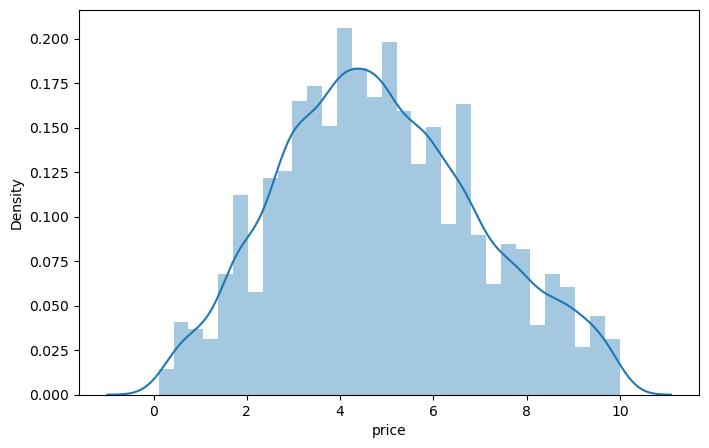

In [15]:
house_data_1 = data.loc[(data['price'] >= 0.1) & (data['price'] < 10)]
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data_1['price'])

c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

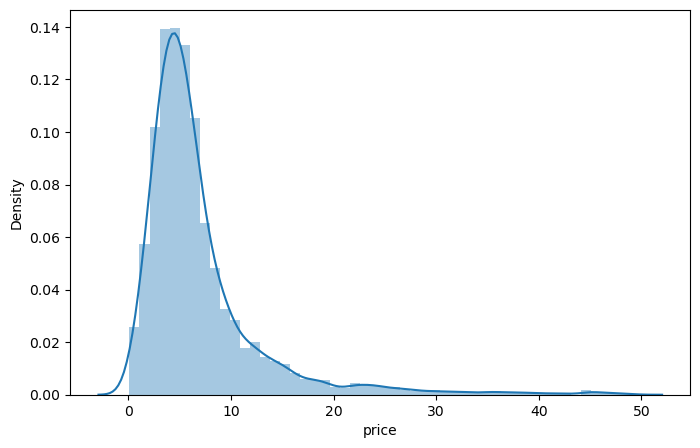

In [16]:
house_data_2 = data.loc[(data['price'] >= 0.1) & (data['price'] < 50)]
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data_2['price'])

In [17]:
house_data = data.loc[(data['price'] >= 0.1) & (data['price'] < 500)]

In [ ]:
house_data.to_excel('house_data.xlsx', index=False)

c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

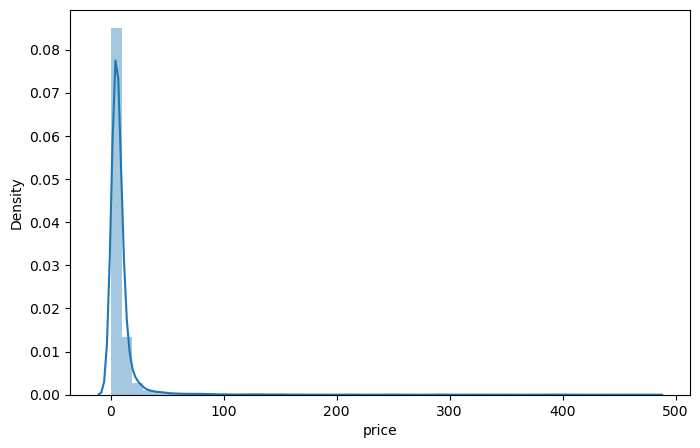

In [18]:
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data['price'])

## Xử lí diện tích

In [19]:
house_data['area'].isna().sum()

124

In [20]:
house_data['area'].describe()

count      8142.000000
mean         97.477207
std        1148.948237
min           3.000000
25%          43.000000
50%          58.000000
75%          84.000000
max      100103.000000
Name: area, dtype: float64

In [21]:
house_data=house_data.loc[(house_data['area'] >=10) & (house_data['area'] <=20000)]

In [22]:
house_data['area'].describe()

count     8096.000000
mean        85.640689
std        303.197151
min         10.000000
25%         44.000000
50%         59.000000
75%         85.000000
max      18264.000000
Name: area, dtype: float64

c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='area', ylabel='Density'>

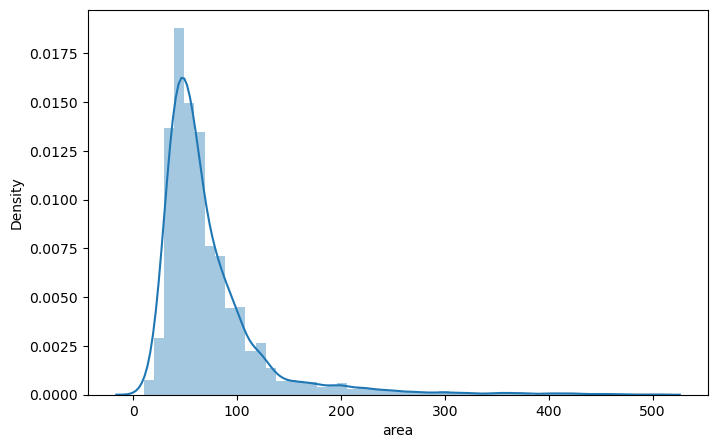

In [23]:
house_data_3 = house_data.loc[(house_data['area'] >=10) & (house_data['area'] <=500)]
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data_3['area'])

# Xử lý num_floors



In [24]:
house_data['num_floors'].describe()

count    6416.000000
mean        3.386222
std         5.116125
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max       345.000000
Name: num_floors, dtype: float64

In [25]:
filtered_data = house_data[house_data['num_floors'] > 11]
print(filtered_data[['num_floors', 'price']])


      num_floors   price
580         65.0    5.65
1153        15.0    2.65
2001        16.0    1.70
2132        17.0    2.20
2735        27.0  125.00
4909        28.0    3.70
5431        65.0    1.65
5436        75.0    1.75
5650        12.0    6.70
5788        29.0    3.80
5974        30.0    3.70
5989        28.0    3.70
6050        28.0    0.34
6560       345.0    8.75
6692        43.0    6.00
6782        18.0    4.50
7927        89.0    1.89
7935        35.0    2.35
7936        89.0    2.89
7970        12.0    1.25


In [26]:
house_data = house_data.drop(house_data[house_data['num_floors'] == 27].index).reset_index(drop=True)


In [27]:
house_data.loc[house_data['num_floors'] > 11, 'num_floors'] = 1


In [28]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
# Tạo tập dữ liệu chỉ chứa các dòng có giá trị không bị thiếu trong cột 'num_floors' và 'price'
train_data = house_data.dropna(subset=['num_floors', 'price'])


In [29]:
X_train = train_data[['price']]
y_train = train_data['num_floors']
X_test = house_data.loc[house_data['num_floors'].isna(), ['price']]

In [30]:
X_test

,price
1,2.90
8,4.50
10,1.08
24,3.15
40,3.20
...,...
8073,6.49
8075,4.90
8086,1.77
8091,9.50


In [196]:
# Huấn luyện mô hình Linear Regression trên tập dữ liệu không bị thiếu
regressor.fit(X_train, y_train)

LinearRegression()

In [197]:
# Dự đoán giá trị thiếu trong cột 'num_floors' dựa trên giá (price)
predicted_values = regressor.predict(X_test)

In [204]:
# Làm tròn giá trị dự đoán thành số nguyên
predicted_values_rounded = np.round(predicted_values).astype(int)


In [205]:
predicted_values_rounded

array([3, 3, 3, ..., 3, 3, 3])

In [199]:
# Cập nhật giá trị thiếu trong cột 'num_floors' với các giá trị dự đoán đã làm tròn
house_data.loc[house_data['num_floors'].isna(), 'num_floors'] = predicted_values_rounded

In [31]:
house_data['num_floors'].describe()

count    6415.000000
mean        3.223539
std         1.609696
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        11.000000
Name: num_floors, dtype: float64

c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='num_floors', ylabel='Density'>

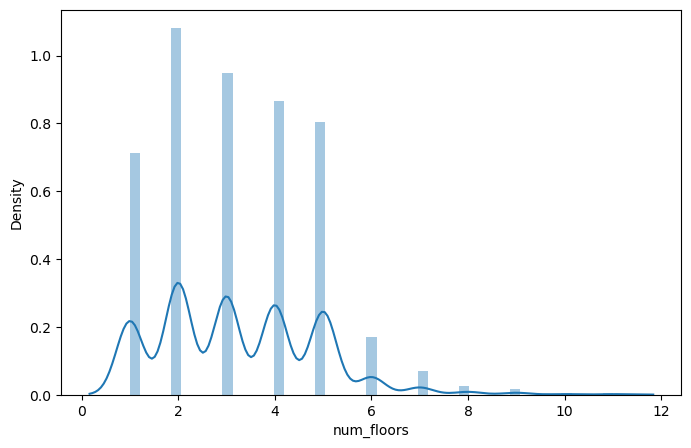

In [32]:
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data['num_floors'])

In [33]:
house_data.isna().sum()

houseTypes       0
area             0
num_floors    1680
bedrooms      1708
district         0
city             0
price            0
url              0
dtype: int64

In [34]:
house_data.to_excel('new_house_data.xlsx', index=False)

# Xử lý bedrooms

In [35]:
house_data['bedrooms'].describe()

count    6387.000000
mean        3.703304
std         3.465249
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max       111.000000
Name: bedrooms, dtype: float64

c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bedrooms', ylabel='Density'>

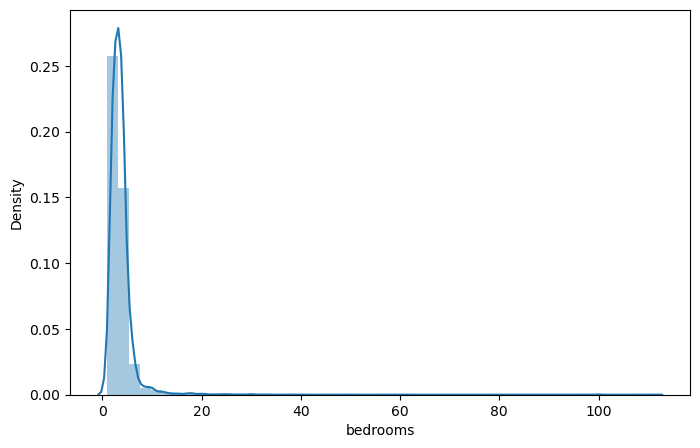

In [36]:
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data['bedrooms'])

In [132]:
many_bedrooms = house_data[house_data['bedrooms']>20]
print(len(many_bedrooms))
print(many_bedrooms.head(30))
many_bedrooms.to_excel('many_bedrooms.xlsx', index=False)

30
           houseTypes    area  num_floors  bedrooms    district  \
610   Bán Nhà mặt phố  1518.0         1.0      30.0     Thủ Đức   
760   Bán Nhà mặt phố  1518.0         1.0      30.0     Thủ Đức   
814     Bán Nhà riêng   270.0         5.0      50.0    Tân Bình   
1175    Bán Nhà riêng   350.0         8.0     111.0    Tân Bình   
1295  Bán Nhà mặt phố   100.0         9.0      24.0     Sơn Trà   
1373    Bán Nhà riêng    77.0         2.0      33.0         Huế   
1645    Bán Nhà riêng    75.0         7.0      24.0  Thanh Xuân   
2318    Bán Nhà riêng   165.0         9.0      61.0    Cầu Giấy   
2385    Bán Nhà riêng   558.0         5.0      65.0      Quận 7   
2490  Bán Nhà mặt phố   435.0         9.0     100.0      Quận 7   
2790  Bán Nhà mặt phố   137.0         7.0      25.0      Quận 3   
3551  Bán Nhà mặt phố   800.0         5.0     100.0      Quận 7   
4143    Bán Nhà riêng    65.0         9.0      21.0   Thanh Trì   
4307  Bán Nhà mặt phố   170.0         6.0      28.0     Quậ

In [37]:
filtered_data2 = house_data[house_data['bedrooms'] > 20]
print(filtered_data2[['bedrooms', 'num_floors']])

      bedrooms  num_floors
610       30.0         NaN
760       30.0         NaN
814       50.0         5.0
1175     111.0         8.0
1295      24.0         9.0
1373      33.0         2.0
1645      24.0         7.0
2318      61.0         9.0
2385      65.0         5.0
2490     100.0         9.0
2789      25.0         7.0
3550     100.0         5.0
4142      21.0         9.0
4306      28.0         6.0
4360      36.0         3.0
4553      22.0         2.0
4742      27.0         6.0
4838      30.0         8.0
4874      30.0         8.0
5077      32.0         6.0
5080      40.0         9.0
5131      23.0         4.0
5133      25.0         3.0
5666      26.0         6.0
6298      28.0         4.0
7005      23.0         6.0
7351      33.0         6.0
7564      38.0         2.0
7684      21.0         6.0
7748      25.0         8.0


In [25]:
# new_low_price = []
# for url in low_noise_data['url']:
#     match = re.search(r'(\d+)-ty', url) or re.search(r'(\d+)ty-', url) or re.search(r'(\d+)-ti', url)
#     if match:
#         number = match.group(1)
#         if int(number) <= 10:
#             new_low_price.append(float(number))
#         elif int(number) <= 100:
#             new_low_price.append(float(number)/10)
#         else:
#             new_low_price.append(float(number)/100)
#     else:
#         match = re.search(r'(\d+)-trieu-', url) or re.search(r'(\d+)tr-', url) or re.search(r'(\d+)trieu-', url)
#         if match:
#             number = match.group(1)
#             new_low_price.append(float(number)/1000)
#         else:
#             new_low_price.append(0)
  
# -2ty5-    -70trm2-    -2x-ty-  -4ty95-    -2ty2x-     -shr6ty120-  -360trphan             

In [26]:
# new_price =[]
# count_error = 0
# for url in low_noise_data['url']:
#     match = re.search(r'(\d+)-ty', url) 
#     if match:
#         number = match.group(1)
#         if int(number) > 10 & int(number) < 100:
#             new_price.append(float(number)/10)
#         elif int(number) >= 100:
#             new_price.append(float(number)/100)
#         else:
#             new_price.append(float(number))
#     else:
#         match =  re.search(r'(\d+)tr', url)
#         if match:
#             new_price.append(float(match.group(1))/1000)
#         elif match == None:
#             try:
#                 data = requests.get(url)
#                 soup = BeautifulSoup(data.text, 'lxml')
#                 if data:
#                     if(soup.find('div',{'class':'project-global-object-block-003 information-custom'}) and soup.find('div',{'class':'content'})):
#                         text_info=""
#                         text_info = soup.find('div',{'class':'project-global-object-block-003 information-custom'}).text.strip() + soup.find('div',{'class':'content'}).text.strip().replace('\n','')
#                         text_info = text_info.replace("\r"," ")
#                         text_info = text_info.replace("\n"," ")
#                         text_info = text_info.replace("\t"," ")
#                         z = re.search(r"(\d+(?:\.\d+)?(?:,\d+)?) Tỷ", text_info, re.IGNORECASE)
#                         if z:
#                             new_price.append(float(z.group(1)))
#             except:
#                 print("error")
#                 new_price.append(0.00001)
#         else:
#             new_price.append(0.00001)

# len(low_noise_data)
# #low_noise_data['new_price'] = new_price
# new_price

In [38]:
len(house_data)

8095

In [39]:
print("Missing Values by Column")
print("-"*30)
print(house_data.isna().sum())
print("-"*30)
print("TOTAL MISSING VALUES:",house_data.isna().sum().sum())

Missing Values by Column
------------------------------
houseTypes       0
area             0
num_floors    1680
bedrooms      1708
district         0
city             0
price            0
url              0
dtype: int64
------------------------------
TOTAL MISSING VALUES: 3388


<AxesSubplot:>

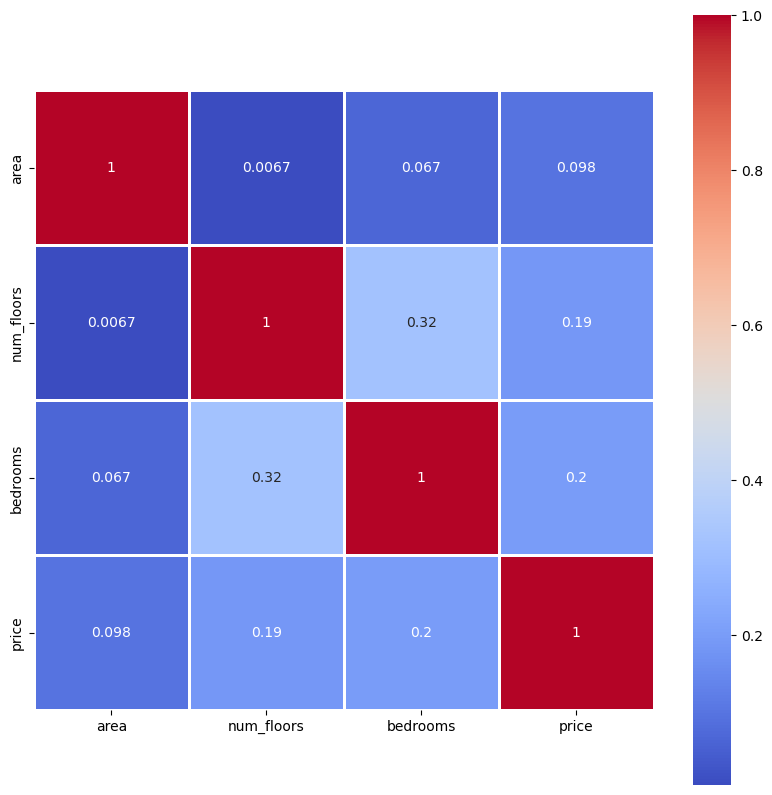

In [40]:
plt.figure(figsize=(10,10))
sns.heatmap(house_data.corr(), square=True ,annot=True, linewidths=1,cmap="coolwarm")

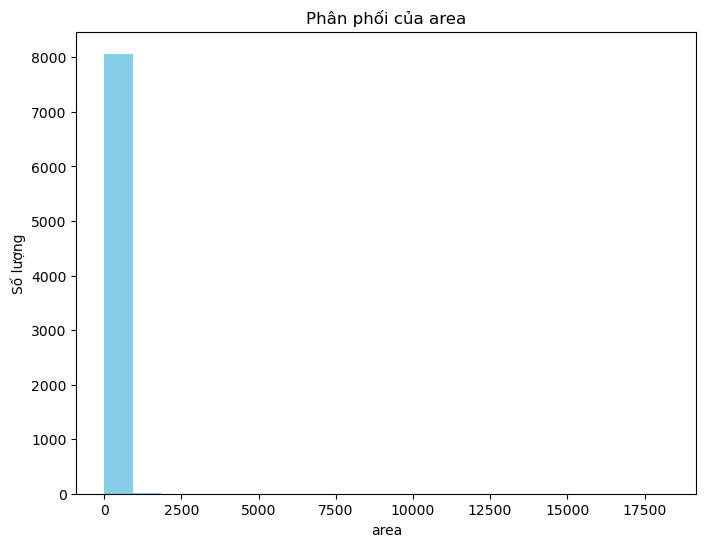

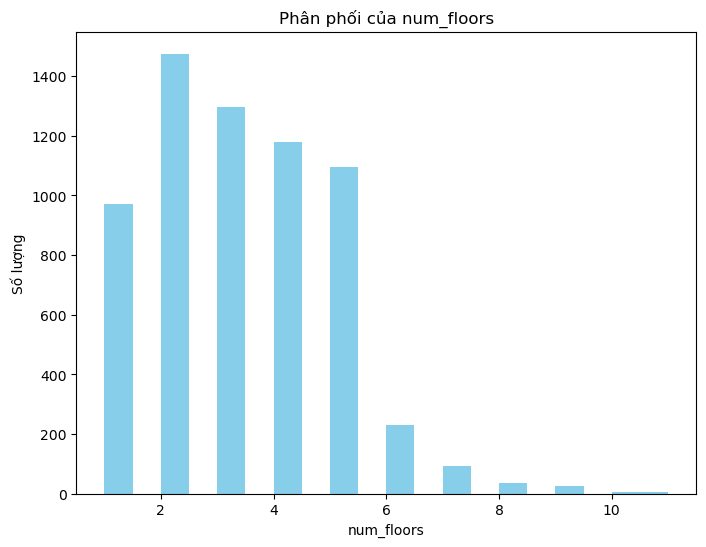

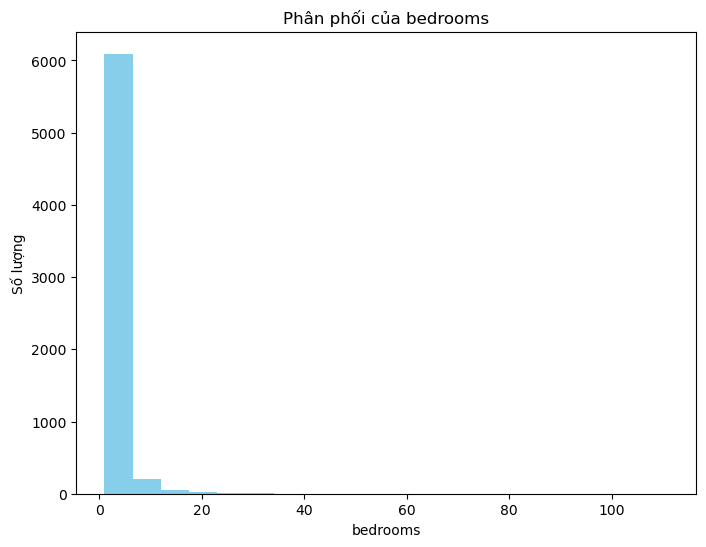

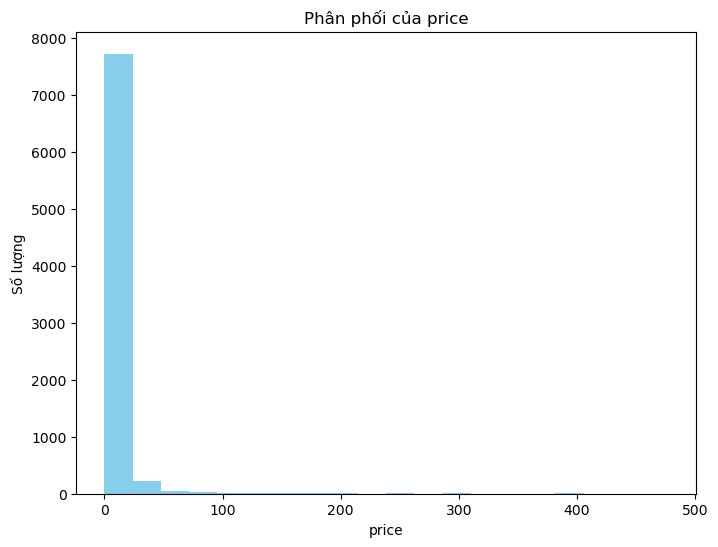

In [41]:

# Danh sách các feature cần xem phân phối
features = ['area','num_floors','bedrooms','price']

# Vẽ biểu đồ phân phối của các feature
for feature in features:
    plt.figure(figsize=(8, 6))
    plt.hist(house_data[feature], bins=20, color='skyblue')
    plt.xlabel(feature)
    plt.ylabel('Số lượng')
    plt.title('Phân phối của ' + feature)
    plt.show()

In [105]:
new_house_data = pd.read_excel('new_house_data.xlsx')
new_house_data.drop(['district','url'],axis=1,inplace=True)


In [106]:
print("Missing Values by Column")
print("-"*30)
print(new_house_data.isna().sum())
print("-"*30)
print("TOTAL MISSING VALUES:",new_house_data.isna().sum().sum())

Missing Values by Column
------------------------------
houseTypes       0
area             0
num_floors    1680
bedrooms      1708
city             0
price            0
dtype: int64
------------------------------
TOTAL MISSING VALUES: 3388


In [95]:
print(new_house_data['city'].nunique())

38


# OneHotEncoder

In [107]:
from sklearn.preprocessing import OneHotEncoder
# Tạo một đối tượng OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Chọn cột cần mã hóa
columns_to_encode = ['houseTypes','city']

# Mã hóa one-hot cho các cột
encoded_data = encoder.fit_transform(new_house_data[columns_to_encode])


# Tạo DataFrame mới từ dữ liệu đã mã hóa
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names(columns_to_encode))

# Xóa các cột gốc trong biến data
new_house_data.drop(columns_to_encode, axis=1, inplace=True)

# Kết hợp dữ liệu đã mã hóa với biến data
new_house_data = pd.concat([new_house_data, encoded_df], axis=1)

# In ra 5 dòng đầu tiên của dữ liệu sau khi mã hóa
print(new_house_data.head())

    area  num_floors  bedrooms  price  houseTypes_Bán Luxury home  \
0  130.0         3.0       7.0    9.2                         0.0   
1   65.0         NaN       2.0    2.9                         0.0   
2   90.0         5.0       5.0   14.0                         0.0   
3   30.0         1.0       2.0    3.7                         0.0   
4   38.0         3.0       3.0    4.4                         0.0   

   houseTypes_Bán Nhà  houseTypes_Bán Nhà cổ  houseTypes_Bán Nhà mặt phố  \
0                 0.0                    0.0                         0.0   
1                 0.0                    0.0                         0.0   
2                 0.0                    0.0                         0.0   
3                 0.0                    0.0                         0.0   
4                 0.0                    0.0                         0.0   

   houseTypes_Bán Nhà riêng  city_An Giang  ...  city_Thanh Hóa  \
0                       1.0            0.0  ...             0

c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [108]:
print(new_house_data.to_excel('oneHot.xlsx', index=False))

None


# Label Encoder

In [109]:
new_house_data = pd.read_excel('new_house_data.xlsx')
new_house_data.drop(['district','url'],axis=1,inplace=True)

In [111]:
from sklearn.preprocessing import LabelEncoder

# Tạo một đối tượng LabelEncoder
label_encoder = LabelEncoder()

# Mã hóa nhãn cho cột 'loại nhà'
new_house_data['houseTypes_encoded'] = label_encoder.fit_transform(new_house_data['houseTypes'])

# Mã hóa nhãn cho cột 'city'
new_house_data['city_encoded'] = label_encoder.fit_transform(new_house_data['city'])

new_house_data.drop(['city','houseTypes'],axis=1,inplace=True)

# In ra 5 dòng đầu tiên của dữ liệu đã mã hóa
print(new_house_data.head())

    area  num_floors  bedrooms  price  houseTypes_encoded  city_encoded
0  130.0         3.0       7.0    9.2                   4            27
1   65.0         NaN       2.0    2.9                   4            35
2   90.0         5.0       5.0   14.0                   4            11
3   30.0         1.0       2.0    3.7                   4            27
4   38.0         3.0       3.0    4.4                   4            27


In [113]:
print(new_house_data.to_excel('Label.xlsx', index=False))

None


# TargetEncoder for city and OneHot for housetypes 

In [66]:
new_house_data = pd.read_excel('data/houses/not_null_houses.xlsx')
new_house_data.drop(['district','url'],axis=1,inplace=True)


In [81]:
#pip install category_encoders

In [82]:
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

target_encoder =ce.TargetEncoder() 

new_house_data['city_target_encoder'] = new_house_data['city']
df_city = target_encoder.fit_transform(new_house_data['city_target_encoder'],new_house_data['price'])
df_new = df_city.join(new_house_data.drop('city_target_encoder',axis = 1))

# Tạo một đối tượng OneHotEncoder
encoder = OneHotEncoder(sparse=False)
# Chọn cột cần mã hóa
columns_to_encode = ['houseTypes']
# Mã hóa one-hot cho các cột
encoded_data = encoder.fit_transform(new_house_data[columns_to_encode])
# Tạo DataFrame mới từ dữ liệu đã mã hóa
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

# Xóa các cột gốc trong biến data
df_new.drop(columns_to_encode, axis=1, inplace=True)

# Kết hợp dữ liệu đã mã hóa với biến data
df_new = pd.concat([df_new, encoded_df], axis=1)

print(df_new.head())

   city_target_encoder  index   area  num_floors  bedrooms            city  \
0             8.644173      0  130.0           3         7  TP Hồ Chí Minh   
1             8.941202      2   90.0           5         5          Hà Nội   
2             8.644173      4   30.0           1         2  TP Hồ Chí Minh   
3             8.644173      5   38.0           3         3  TP Hồ Chí Minh   
4             8.644173      6   45.0           2         2  TP Hồ Chí Minh   

   price  new_num_floors  new_bedrooms        city_new  \
0    9.2               3             7  TP Hồ Chí Minh   
1   14.0               5             5          Hà Nội   
2    3.7               3             3  TP Hồ Chí Minh   
3    4.4               2             2  TP Hồ Chí Minh   
4    3.9               6             4  TP Hồ Chí Minh   

   houseTypes_Bán Luxury home  houseTypes_Bán Nhà  houseTypes_Bán Nhà cổ  \
0                         0.0                 0.0                    0.0   
1                         0.0 

/opt/homebrew/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [83]:
print(df_new.to_excel('data/houses/Target.xlsx', index=False))

None


 # Initialize google map


In [45]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='my_app')

# Tạo đối tượng geocoder
geocoder = geolocator.geocode

# Geocode the addresses to obtain latitude and longitude coordinates
locations = [geocoder(f"{district}, {city}") for district, city in zip(house_data['district'][0:100], house_data['city'][0:100])]

# Extract latitude and longitude coordinates from the locations
latitude = [location.latitude for location in locations]
longitude = [location.longitude for location in locations]

# Mark points on google map

In [46]:
lat = 10.861410750000001
long = 106.66420925636413
zoom = 6
gmap2 = folium.Map(location=(lat, long), zoom_start=zoom)
def _addMarker(latitudes, longitudes,gmap):
    # Kiểm tra độ dài của danh sách latitude và longitude
    if len(latitudes) != len(longitudes):
        print("Danh sách latitude và longitude không cùng độ dài.")
        return
    # Thêm Marker vào map_obj
    for lat, lng in zip(latitudes, longitudes):
        marker = folium.Marker(location=(lat, lng))
        marker.add_to(gmap)
_addMarker(latitude,longitude,gmap2)
gmap2.save("foliumMarkerMultiple.html")

# Heatmap

In [47]:
from folium.plugins import HeatMap

lat = 10.861410750000001
long = 106.66420925636413
zoom = 6
gmap2 = folium.Map(location=(lat, long), zoom_start=zoom)
maximum = max(house_data['price'])

def _addHeatMap(map_obj, latitudes, longitudes, values):
    # Tạo danh sách các tọa độ (latitude, longitude, value)
    data = list(zip(latitudes, longitudes, values))
    # Tạo HeatMap từ danh sách tọa độ và values
    heat_map = HeatMap(data)
    # Thêm HeatMap vào bản đồ
    map_obj.add_child(heat_map)
_addHeatMap(gmap2,latitude,longitude,house_data['price'][0:100])
gmap2.save("foliumHeatMap.html")

# Derived features


### Standalize

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
features_remove_target = ['city_area', 'population', 'gdp']

In [85]:

df_unit = df_city = pd.read_excel('data/city_features/city.xlsx')
df_tranform = pd.DataFrame(data = StandardScaler().fit_transform(df_unit.loc[:, features_remove_target ].values), columns = features_remove_target)


### PCA


In [86]:
pca = PCA(n_components = 1)
component = pd.DataFrame(pca.fit_transform(df_tranform.values), columns = ['city_index'])
df_city_index = pd.concat([df_unit['city'], component], axis=1)
print(df_city_index)

               city  city_index
0          An Giang   -0.092849
1   Bà Rịa Vũng Tàu    3.842388
2          Bạc Liêu   -0.257118
3         Bắc Giang    0.278812
4           Bắc Kạn   -0.963055
..              ...         ...
58         Trà Vinh   -0.031466
59      Tuyên Quang   -0.823390
60        Vĩnh Long    0.050324
61        Vĩnh Phúc    0.994318
62          Yên Bái   -0.991059

[63 rows x 2 columns]


In [87]:
df_house = pd.read_excel("data/houses/Target.xlsx")

In [96]:
new_df = pd.merge(df_house, df_city_index, on= 'city')
new_df = new_df[['price',\
        'city',\
        'city_target_encoder',\
        'city_index',\
        'area',\
        'new_num_floors',\
        'new_bedrooms',\
        'houseTypes_Bán Luxury home',\
        'houseTypes_Bán Nhà',\
        'houseTypes_Bán Nhà cổ',\
        'houseTypes_Bán Nhà mặt phố',\
        'houseTypes_Bán Nhà riêng']]

In [ ]:
features = ['price',\
        'city',\
        'city_target_encoder',\
        'city_index',\
        'area',\
        'new_num_floors',\
        'new_bedrooms',\
        'houseTypes_Bán Luxury home',\
        'houseTypes_Bán Nhà',\
        'houseTypes_Bán Nhà cổ',\
        'houseTypes_Bán Nhà mặt phố',\
        'houseTypes_Bán Nhà riêng']

In [ ]:
print(new_df.to_excel('final_data.xlsx', index=False))

In [99]:
new_df.describe

<bound method NDFrame.describe of         price            city  city_target_encoder  city_index   area  \
0      9.2000  TP Hồ Chí Minh             8.644173    3.710867  130.0   
1      3.7000  TP Hồ Chí Minh             8.644173    3.710867   30.0   
2      4.4000  TP Hồ Chí Minh             8.644173    3.710867   38.0   
3      3.9000  TP Hồ Chí Minh             8.644173    3.710867   45.0   
4     12.7000  TP Hồ Chí Minh             8.644173    3.710867   51.0   
...       ...             ...                  ...         ...    ...   
4961   4.0000      Bình Thuận             8.659372   -0.515325  108.0   
4962  16.5000      Bình Thuận             8.659372   -0.515325  140.0   
4963   7.5000      Bình Thuận             8.659372   -0.515325  150.0   
4964   0.1972         Yên Bái             7.451269   -0.991059   68.0   
4965   4.1200       Sóc Trăng             7.961659   -0.392208  279.0   

      new_num_floors  new_bedrooms  houseTypes_Bán Luxury home  \
0                  3   